In [ ]:
!pip install numpy scipy matplotlib xarray pandas scikit-learn tensorflow netcdf4 h5netcdf tqdm s3fs zarr

In [ ]:
# if working on google colab
! pip install -U -q PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Module imports 
import argparse
import random
import os
from os.path import join, exists
import sys
import s3fs
import yaml
import zarr
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, max_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam, SGD

seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Limit GPU memory usage
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
# define some datset helper functions

num_particles_dict = {
    1 : '1particle',
    3 : '3particle',
    'multi': 'multiparticle'}

split_dict = {
    'train' : 'training',
    'test'   : 'test',
    'valid': 'validation'}

def dataset_name(num_particles, split, file_extension='zarr'):
    """
    Return the dataset filename given user inputs
    
    Args: 
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
        file_extension: (str) Dataset file extension
    
    Returns:
        dataset: (str) Dataset name
    """
    
    valid = [1,3,'multi']
    if num_particles not in valid:
        raise ValueError("results: num_particles must be one of %r." % valid)
    num_particles = num_particles_dict[num_particles]
    
    valid = ['train','test','valid']
    if split not in valid:
        raise ValueError("results: split must be one of %r." % valid)
    split = split_dict[split]
    
    return f'synthetic_holograms_{num_particles}_{split}_small.{file_extension}'

def open_zarr(path_data, num_particles, split):
    """
    Open a HOLODEC Zarr file hosted on AWS
    
    Args: 
        path_data: (str) Path to directory containing datset
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
    
    Returns:
        dataset: (xarray Dataset) Opened dataset
    """
    path_data = os.path.join(path_data, dataset_name(num_particles, split))
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    store = s3fs.S3Map(root=path_data, s3=fs, check=False)
    dataset = xr.open_zarr(store=store)
    return dataset

def scale_images(images, scaler_vals=None):
    """
    Takes in array of images and scales pixel values between 0 and 1
    
    Args: 
        images: (np array) Array of images 
        scaler_vals: (dict) Image scaler 'max' and 'min' values
        
    Returns:
        images_scaled: (np array) Scaled array of images with pixel values between 0 and 1
        scaler_vals: (dict) Image scaler 'max' and 'min' values
    """
    
    if scaler_vals == None:
        scaler_vals = {}
        scaler_vals["min"] = images.min()
        scaler_vals["max"] = images.max()
    images_scaled = (images.astype(np.float32) - scaler_vals["min"]) / (scaler_vals["max"] - scaler_vals["min"])
    return images_scaled, scaler_vals

def load_scaled_datasets(path_data, num_particles, output_cols, slice_idx,
                         split='train', scaler_vals=None):
    """
    Given a path to training or validation datset, the number of particles per
    hologram, and output columns, returns scaled inputs and raw outputs.
    
    Args: 
        path_data: (str) Path to directory containing training and validation datsets
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi') 
        output_cols: (list of strings) List of feature columns to be used
        
    Returns:
        inputs_scaled: (np array) Input data scaled between 0 and 1
        outputs: (df) Output data specified by output_cols
        scaler_vals: (dict) list of training/validation/test files
    """
    
    if split == 'valid':
      slice_idx = int(slice_idx/3)
    print("Slicing data into inputs/outputs")
    ds = open_zarr(path_data, num_particles, split)
    inputs = ds["image"].values[:slice_idx]
    outputs = ds[output_cols].to_dataframe().loc[:slice_idx-1,:]
    ds.close()
    print(f"\t- outputs.shape: {outputs.shape}")

    print("Scaling input data")
    if split == 'train':
      inputs_scaled, scaler_vals = scale_images(inputs)
    else:
      slice_idx = int(slice_idx/3)
      inputs_scaled, _ = scale_images(inputs, scaler_vals)
  
    inputs_scaled = np.expand_dims(inputs_scaled, -1)
    print(f"\t- inputs_scaled.shape: {inputs_scaled.shape}")

    return inputs_scaled, outputs, scaler_vals

In [ ]:
# data definitions

path_data = "ncar-aiml-data-commons/holodec/"
num_particles = 1
output_cols_one  = ["x", "y", "z", "d"]
scaler_one = MinMaxScaler()
slice_idx = 3000

In [ ]:
# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled_one,\
train_outputs_one,\
scaler_vals_one = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols_one,
                                   slice_idx)

valid_inputs_scaled_one,\
valid_outputs_one, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols_one,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals_one)

# extra transform step for output_cols_one in lieu of z mass

train_outputs_scaled_one = scaler_one.fit_transform(train_outputs_one[output_cols_one])
valid_outputs_scaled_one = scaler_one.transform(valid_outputs_one[output_cols_one])


Slicing data into inputs/outputs
	- outputs.shape: (3000, 4)
Scaling input data
	- inputs_scaled.shape: (3000, 600, 400, 1)
Slicing data into inputs/outputs
	- outputs.shape: (1000, 4)
Scaling input data
	- inputs_scaled.shape: (1000, 600, 400, 1)


In [ ]:
class Conv2DNeuralNetwork(object):
    """2D
    A Conv2D Neural Network Model that can support arbitrary numbers of layers.

    Attributes:
        filters: List of number of filters in each Conv2D layer
        kernel_sizes: List of kernel sizes in each Conv2D layer
        conv2d_activation: Type of activation function for conv2d layers
        pool_sizes: List of Max Pool sizes
        dense_sizes: Sizes of dense layers
        dense_activation: Type of activation function for dense layers
        output_activation: Type of activation function for output layer
        lr: Optimizer learning rate
        optimizer: Name of optimizer or optimizer object.
        adam_beta_1: Exponential decay rate for the first moment estimates
        adam_beta_2: Exponential decay rate for the first moment estimates
        sgd_momentum: Stochastic Gradient Descent momentum
        decay: Optimizer decay
        loss: Name of loss function or loss object
        batch_size: Number of examples per batch
        epochs: Number of epochs to train
        verbose: Level of detail to provide during training
        model: Keras Model object
    """
    def __init__(self, filters=(8,), kernel_sizes=(5,), conv2d_activation="relu",
                 pool_sizes=(4,), dense_sizes=(64,), dense_activation="relu", output_activation="softmax",
                 lr=0.001, optimizer="adam",  adam_beta_1=0.9, adam_beta_2=0.999,
                 sgd_momentum=0.9, decay=0, loss="mse", batch_size=32, epochs=2, verbose=0):
        self.filters = filters
        self.kernel_sizes = [tuple((v,v)) for v in kernel_sizes]
        self.conv2d_activation = conv2d_activation
        self.pool_sizes = [tuple((v,v)) for v in pool_sizes]
        self.dense_sizes = dense_sizes
        self.dense_activation = dense_activation
        self.output_activation = output_activation
        self.lr = lr
        self.optimizer = optimizer
        self.optimizer_obj = None
        self.adam_beta_1 = adam_beta_1
        self.adam_beta_2 = adam_beta_2
        self.sgd_momentum = sgd_momentum
        self.decay = decay
        self.loss = loss
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.model = None

    def build_neural_network(self, input_shape, output_shape):
        """Create Keras neural network model and compile it."""
        conv_input = Input(shape=(input_shape), name="input")
        nn_model = conv_input
        for h in range(len(self.filters)):
            nn_model = Conv2D(self.filters[h], self.kernel_sizes[h], padding="same",
                              activation=self.conv2d_activation, name=f"conv2D_{h:02d}")(nn_model)
            nn_model = MaxPool2D(self.pool_sizes[h], name=f"maxpool2D_{h:02d}")(nn_model)
        nn_model = Flatten()(nn_model)
        for h in range(len(self.dense_sizes)):
            nn_model = Dense(self.dense_sizes[h], activation=self.dense_activation, name=f"dense_{h:02d}")(nn_model)
        nn_model = Dense(output_shape, activation=self.output_activation, name=f"dense_output")(nn_model)
        self.model = Model(conv_input, nn_model)
        if self.optimizer == "adam":
            self.optimizer_obj = Adam(lr=self.lr, beta_1=self.adam_beta_1, beta_2=self.adam_beta_2, decay=self.decay)
        elif self.optimizer == "sgd":
            self.optimizer_obj = SGD(lr=self.lr, momentum=self.sgd_momentum, decay=self.decay)
        
        self.model.compile(optimizer=self.optimizer, loss=self.loss)
        self.model.summary()

    def fit(self, x, y, xv, yv):
        if len(y.shape) == 1:
            output_shape = 1
        else:
            output_shape = y.shape[1]
        input_shape = x.shape[1:]
        self.build_neural_network(input_shape, output_shape)
        self.model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs,
                       verbose=self.verbose, validation_data=(xv, yv))
        return self.model.history.history

    def predict(self, x):
        y_out = self.model.predict(x, batch_size=self.batch_size)
        return y_out

    def predict_proba(self, x):
        y_prob = self.model.predict(x, batch_size=self.batch_size)
        return y_prob

In [ ]:
model_histories = []

In [ ]:
# conv2d_network definitions for 1 particle 4D solution
#we updated and tuned the hyperparameters to minimize loss
#this included adding more layers to the CNN, changing the optimizer and loss, and changing batch size to 1
#with this tuning, the loss is less sensitive to learning rate and does not reach overfitting
IN_COLAB = 'google.colab' in sys.modules
path_out = "/content/gdrive/My Drive/micro_models/1particle_base"
if not exists(path_out):
    os.makedirs(path_out)
model_name = "cnn"
filters = [16, 24, 32, 44]
kernel_sizes = [5, 5, 5, 5]
conv2d_activation = "relu"
pool_sizes = [4, 4, 4, 4]
dense_sizes = [64, 32, 24]
dense_activation = "relu"
lr = 0.001
optimizer = "Adamax"
loss = "mse"
batch_size = 1
epochs = 40
verbose = 1

if not exists(path_out):
    os.makedirs(path_out)

In [ ]:
# 1 particle 4D model build, compile, fit, and predict

one_start = datetime.now()
with tf.device('/device:GPU:0'):
    mod = Conv2DNeuralNetwork(filters=filters, kernel_sizes=kernel_sizes, conv2d_activation=conv2d_activation,
                     pool_sizes=pool_sizes, dense_sizes=dense_sizes, dense_activation=dense_activation,
                     lr=lr, optimizer=optimizer, loss=loss, batch_size=batch_size, epochs=epochs, verbose=verbose)
    hist = mod.fit(train_inputs_scaled_one, train_outputs_scaled_one, valid_inputs_scaled_one, valid_outputs_scaled_one)
    
    train_preds_scaled_one = pd.DataFrame(mod.predict(train_inputs_scaled_one), columns=output_cols_one)
    valid_preds_scaled_one = pd.DataFrame(mod.predict(valid_inputs_scaled_one), columns=output_cols_one)
print(f"Running model took {datetime.now() - one_start} time")
model_histories.append(hist)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 600, 400, 1)]     0         
_________________________________________________________________
conv2D_00 (Conv2D)           (None, 600, 400, 16)      416       
_________________________________________________________________
maxpool2D_00 (MaxPooling2D)  (None, 150, 100, 16)      0         
_________________________________________________________________
conv2D_01 (Conv2D)           (None, 150, 100, 24)      9624      
_________________________________________________________________
maxpool2D_01 (MaxPooling2D)  (None, 37, 25, 24)        0         
_________________________________________________________________
conv2D_02 (Conv2D)           (None, 37, 25, 32)        19232     
_________________________________________________________________
maxpool2D_02 (MaxPooling2D)  (None, 9, 6, 32)          0  

[{'loss': [0.14606048166751862, 0.12128443270921707, 0.10289492458105087, 0.09852700680494308, 0.09533362090587616, 0.09335126727819443, 0.09200030565261841, 0.09110025316476822, 0.09062621742486954, 0.0901823341846466, 0.08999761193990707, 0.08978533744812012, 0.08961872011423111, 0.08945808559656143, 0.08931206166744232, 0.0891931876540184, 0.08909051865339279, 0.08905240148305893, 0.08897840231657028, 0.08894898742437363], 'val_loss': [0.14189746975898743, 0.10538791865110397, 0.1002257689833641, 0.09486272931098938, 0.0917251706123352, 0.09043538570404053, 0.08864177763462067, 0.08828555047512054, 0.08734402805566788, 0.08750437200069427, 0.08640124648809433, 0.08662179112434387, 0.08596350997686386, 0.08620478212833405, 0.08601756393909454, 0.08591266721487045, 0.08581479638814926, 0.0856587141752243, 0.08573529869318008, 0.08571992814540863]}, {'loss': [0.11949414759874344, 0.1001715287566185, 0.0968429297208786, 0.09486785531044006, 0.09336967766284943, 0.09232126921415329, 0.09

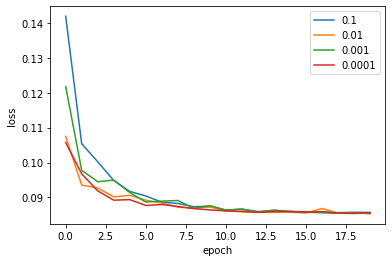

In [ ]:

for hist in model_histories:
  #plt.plot(hist['loss'], label = 'training')
  plt.plot(hist['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# inverse transform of scaled predictions

train_preds_one = pd.DataFrame(scaler_one.inverse_transform(train_preds_scaled_one.values), columns=output_cols_one)
valid_preds_one = pd.DataFrame(scaler_one.inverse_transform(valid_preds_scaled_one.values), columns=output_cols_one)

In [ ]:

valid_maes_one = np.zeros(len(output_cols_one))
max_errors_one = np.zeros(len(output_cols_one))
for o, output_col in enumerate(output_cols_one):
    valid_maes_one[o] = mean_absolute_error(valid_outputs_one[output_col], valid_preds_one[output_col])
    max_errors_one[o] = max_error(valid_outputs_one[output_col], valid_preds_one[output_col])

    print(f"{output_col} MAE: {valid_maes_one[o]:,.0f} µm \t\t Max Error: {max_errors_one[o]:,.0f} µm")

x MAE: 439 µm 		 Max Error: 1,081 µm
y MAE: 305 µm 		 Max Error: 747 µm
z MAE: 35,832 µm 		 Max Error: 103,686 µm
d MAE: 12 µm 		 Max Error: 34 µm


# CNN for a single particle
## Using this structure and tuning hyperparameters

### conv2d_network definitions for 1 particle 4D solution

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    path_out = "/content/gdrive/My Drive/micro_models/1particle_base"
else:
    path_out = "./holodec_models/1particle_base/"
if not exists(path_out):
    os.makedirs(path_out)
model_name = "cnn"
filters = [16, 24, 32]
kernel_sizes = [5, 5, 5]
conv2d_activation = "relu"
pool_sizes = [4, 4, 4]
dense_sizes = [64, 32]
dense_activation = "relu"
lr = 0.001
optimizer = "Adamax"
loss = "mse"
batch_size = 64
epochs = 20
verbose = 1

if not exists(path_out):
    os.makedirs(path_out)



#### We got some results
Ps.: learning rate(LR)

test 0: LR = 0.001, optimizer = adam, loss = mse, batch_size = 64 

test 1: LR = 0.001, optimizer = adam, loss = mse, batch_size = 32

test 2: LR = 0.001, optimizer = rmsprop, loss = mse, batch_size = 64

test 3: LR = 0.001, optimizer = adamax, loss = mse, batch_size = 64

<center><img src='more_tests.png'><center>